## 状態空間モデルで時系列予測を行う（pystan）

In [1]:
%load_ext lab_black

In [2]:
# 必要なライブラリーのインポート
import numpy as np
import pandas as pd
from numpy.random import *
from scipy import stats
import pystan
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# グラフを横長にする
from matplotlib import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set()

# 表示する図表の設定
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 0.3
plt.rcParams["grid.color"] = "grey"
plt.rcParams["figure.figsize"] = (8, 4)

# 可視化に用いる色の設定
maincolor = "#70B145"

INFO:matplotlib.font_manager:generated new fontManager


In [3]:
# データの読み込み
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv("../../data/AirPassengers.csv")

# float型に変換
# df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={"#Passengers": "Passengers"})

# datetime型にしてインデックスにする
# df.Month = pd.to_datetime(df.Month)
# df = df.set_index("Month")

# データの中身を確認
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## ローカルレベルモデル

以下のローカルレベルモデルをStanでベイズ推定します。
\begin{align*}
y_t &= \mu_t + \epsilon_t, &\epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= \mu_{t-1} + \eta_t,  &\eta_t \sim N(0, \sigma_{\mu}^2)
\end{align*}

In [4]:
local_level = """
data {
    int<lower=0> T; // number of learning points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(mu[t], s_y);
    }
    for(t in 2:T) {
        mu[t] ~ normal(mu[t-1], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(mu_pred[t-1], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
"""

In [5]:
stan_model = pystan.StanModel(model_code=local_level)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9bb0ebd023c1c9b55102b36db5240ae9 NOW.


In [6]:
y = df["Passengers"]
T = 137  # 学習期間
M = 7  # 予測期間

y_train = y[:-M]
y_test = y[-M:]

In [7]:
predict_dat = {"T": T, "M": M, "Y": y_train}

In [8]:
fit_local_level = stan_model.sampling(data=predict_dat, iter=8000, chains=2, seed=10)

In [9]:
print(fit_local_level)

Inference for Stan model: anon_model_9bb0ebd023c1c9b55102b36db5240ae9.
2 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        112.09    0.03   3.66  104.0 110.78 112.03 113.34 120.35  13974    1.0
mu[2]        118.12    0.03   3.49  110.8 116.82 118.02 119.32 126.05  13971    1.0
mu[3]        131.83    0.03   3.41 124.15 130.63 131.95 133.14  139.1  14437    1.0
mu[4]        128.98    0.03   3.43 121.27 127.71 129.01 130.24 136.37  13228    1.0
mu[5]        121.27    0.03   3.45 114.03 120.03 121.05 122.48 129.29  11244    1.0
mu[6]         135.0    0.03   3.44 127.49  133.8 135.02 136.22 142.51  12248    1.0
mu[7]        147.86    0.03   3.42 140.16 146.62 147.95 149.17 155.18  14838    1.0
mu[8]         147.8    0.03   3.46 140.16 146.54 147.92 149.07 155.27  11728    1.0
mu[9]        135.88    0.03   3.36 128.19 134.75 135.97

In [10]:
# サンプリング結果の抽出
ms_local_level = fit_local_level.extract()
y_pred = ms_local_level["y_pred"].mean(axis=0)

In [11]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,106.090655,118.347087
1,112.680487,123.797523
2,126.000695,137.166481
3,123.144668,134.654150
4,115.784293,127.064178
...,...,...
139,381.636946,559.489556
140,370.975815,572.834173
141,357.678331,585.653533
142,349.206377,596.861383


In [12]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [13]:
mu_hat = ms_local_level["mu"].mean(axis=0)

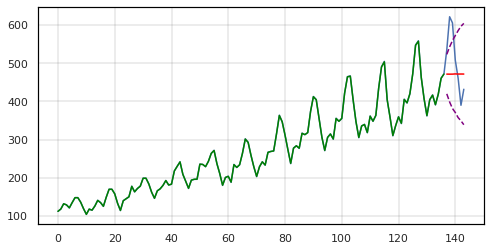

In [14]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.show()

## ローカルレベルモデル(2階差分トレンド)

\begin{align*}
y_t &= \mu_t + \epsilon_t, \epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= 2\mu_{t-1} - \mu_{t-2} + \eta_t,  \eta_t \sim N(0, \sigma_{\mu}^2)
\end{align*}

In [15]:
local_level_smooth = """
data {
    int<lower=0> T; // number of time points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(y_hat[t], s_y);
    }
    for(t in 3:T) {
        mu[t] ~ normal(2*mu[t-1] - mu[t-2], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(2 * mu_pred[t-1] - mu_pred[t-2], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
"""

In [16]:
stan_model = pystan.StanModel(model_code=local_level_smooth)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8e2075ff8b7d910b73b5adc01fd5ffb NOW.


In [17]:
fit_local_level_smooth = stan_model.sampling(
    data=predict_dat, iter=8000, chains=2, seed=10
)

In [18]:
print(fit_local_level_smooth)

Inference for Stan model: anon_model_f8e2075ff8b7d910b73b5adc01fd5ffb.
2 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        113.78    1.87  12.93  88.79 104.87 113.84 122.62 138.89     48   1.06
mu[2]         115.5     1.7  12.22  91.64 107.12 115.63 123.92 139.29     51   1.06
mu[3]        117.22    1.55  11.56  94.53 109.31 117.41 125.17 139.62     56   1.06
mu[4]        118.92    1.41  10.97  97.33 111.46 119.09 126.51 140.22     60   1.06
mu[5]        120.64    1.29  10.43  100.0 113.59 120.72 127.85 140.93     65   1.06
mu[6]        122.35    1.17   9.96 102.52 115.54 122.39 129.17 141.83     73   1.05
mu[7]        124.06    1.05   9.54 105.13 117.51 124.12 130.55 142.82     83   1.05
mu[8]        125.78    0.99   9.18 107.66 119.52 125.79 132.05 144.07     85   1.05
mu[9]        127.52    0.95   8.87 110.07 121.56 127.46

In [19]:
# サンプリング結果の抽出
ms_local_level_smooth = fit_local_level_smooth.extract()
y_pred = ms_local_level_smooth["y_pred"].mean(axis=0)

In [20]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level_smooth["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,92.467962,135.011993
1,95.149151,135.603052
2,97.812741,136.065140
3,100.486155,136.822144
4,103.190826,137.717727
...,...,...
139,426.427747,479.815851
140,427.139477,483.711137
141,427.892672,487.574345
142,428.862003,491.505215


In [21]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [22]:
mu_hat = ms_local_level_smooth["mu"].mean(axis=0)

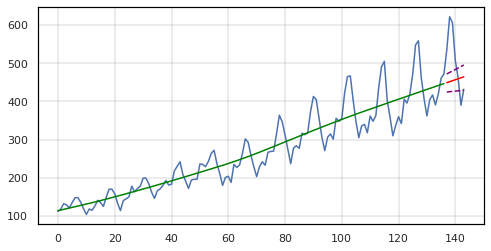

In [23]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.show()

## ローカルレベルモデル+月別効果

\begin{align*}
y_t &= \mu_t + \gamma_t + \epsilon_t, &\epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= 2\mu_{t-1} - \mu_{t-2} + \eta_t,  &\eta_t \sim N(0, \sigma_{\mu}^2)\\
\gamma_t &= -\sum_{l=1}^{11} \gamma_{t-l} + v_t, &v_t \sim N(0, \sigma_{\gamma}^2)
\end{align*}

In [24]:
local_level_smooth_season = """
data {
    int<lower=0> T; // number of time points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real month_eff[T]; // month effect
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
    real<lower=0> s_month; // sd of month effect
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t] + month_eff[t];
    }
}

model {
    for(t in 12:T) {
        month_eff[t] ~ normal(-sum(month_eff[(t-11):(t-1)]), s_month);
    }
    for(t in 1:T) {
        Y[t] ~ normal(y_hat[t], s_y);
    }
    for(t in 3:T) {
        mu[t] ~ normal((2 * mu[t-1] - mu[t-2]), s_mu);
    }
}

generated quantities {
    real month_eff_pred[T+M];
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        month_eff_pred[t] = month_eff[t];
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        month_eff_pred[t] = normal_rng(-sum(month_eff_pred[(t-11):(t-1)]), s_month);
        mu_pred[t] = normal_rng(2 * mu_pred[t-1] - mu_pred[t-2], s_mu);
        y_pred[t] = mu_pred[t] + month_eff_pred[t];
    }
}
"""

In [25]:
stan_model = pystan.StanModel(model_code=local_level_smooth_season)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22e985e390df597b4876aed6d3598b93 NOW.


In [26]:
fit_local_level_smooth_season = stan_model.sampling(
    data=predict_dat, iter=8000, chains=2, seed=10
)

In [27]:
print(fit_local_level_smooth_season)

Inference for Stan model: anon_model_22e985e390df597b4876aed6d3598b93.
2 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
month_eff[1]        -38.62    0.19   7.32 -53.13  -43.4 -38.57 -33.67 -24.24   1473    1.0
month_eff[2]        -26.47    0.15   5.29 -36.98 -30.03 -26.42 -22.97 -15.92   1278    1.0
month_eff[3]         -5.49    0.14   5.16 -15.66  -8.99  -5.36   -2.0   4.69   1355    1.0
month_eff[4]          0.39    0.15   5.22  -9.98  -3.04   0.46   3.86  10.54   1276    1.0
month_eff[5]          4.03    0.14   5.03  -5.81   0.68   4.07    7.3   14.1   1233    1.0
month_eff[6]         30.29    0.16    5.2   20.6  26.75  30.02  33.69  40.95   1103    1.0
month_eff[7]         50.12    0.17   5.45  39.78  46.34  50.04  53.72  61.06   1042    1.0
month_eff[8]         46.93    0.16   5.32  36.74  43.39  46.74  50.41  57.72   1154

In [28]:
# サンプリング結果の抽出
ms_local_level_smooth_season = fit_local_level_smooth_season.extract()
y_pred = ms_local_level_smooth_season["y_pred"].mean(axis=0)

In [29]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,106.090655,118.347087
1,112.680487,123.797523
2,126.000695,137.166481
3,123.144668,134.654150
4,115.784293,127.064178
...,...,...
139,381.636946,559.489556
140,370.975815,572.834173
141,357.678331,585.653533
142,349.206377,596.861383


In [30]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [31]:
# 状態の推定値
mu_hat = ms_local_level_smooth_season["mu"].mean(axis=0)

# 月別効果
month_eff_hat = ms_local_level_smooth_season["month_eff"].mean(axis=0)

# 状態+月別効果
y_hat = ms_local_level_smooth_season["y_hat"].mean(axis=0)

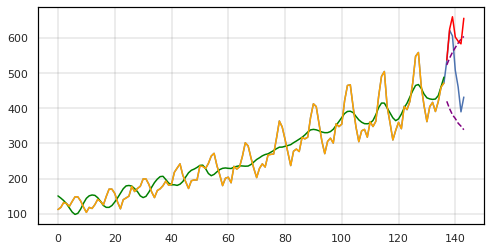

In [32]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.plot(y_hat, color="orange")  # 状態+曜日効果
plt.show()

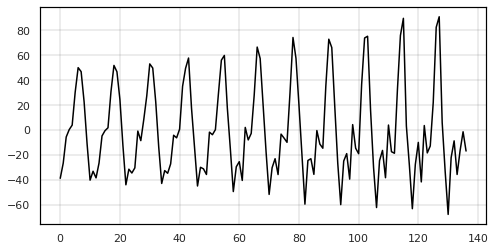

In [33]:
# 月別効果
plt.plot(month_eff_hat, color="black")